In [1]:
import sys
from pathlib import Path
# Get the repository root (1 levels up from current notebook)
repo_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(repo_root))

# import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, mean_absolute_error, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import Template
# Definición de modulos
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling  import SMOTE, ADASYN
from sklearn.decomposition import PCA

# Instantiate the Template class
Template = Template.Template()

# Build the path to the Excel file in the repository root
data_path = os.path.join(repo_root, 'Datos1_InteraccionesNIR_clear.xlsx')
# import the data from all sheets of the Excel file


df6, df7, df8, df12, df13, df14 = [
    pd.read_excel(data_path, sheet_name=i) for i in range(6)
]


df_concatenation = pd.concat([df6, df7, df8, df12, df13, df14], ignore_index=True)

# Referencia principal de Cambio Relativo

In [2]:
RefDf = df6[(df6['Tratamiento'] == 'Control')]

# Extract the relevant columns (from column 2 onwards)
data_cols = RefDf.iloc[:, 2:]

# Calculate the magnitude for each column
magnitudes = []

for col in data_cols.columns:
    # Get the column values
    values = data_cols[col].values
    
    # Take the first value as reference (x)
    x = values[0]
    
    # Calculate |y-x|/x, |z-x|/x, etc. for all other values
    if x != 0:  # Avoid division by zero
        differences = np.abs(values[1:] - x) / x
        # Calculate the magnitude (Euclidean norm)
        magnitude = np.sqrt(np.sum(differences**2))
    else:
        magnitude = np.nan  # Handle zero reference value
    
    magnitudes.append(magnitude)

# Create a dataframe with one row containing all magnitudes
df_mag = pd.DataFrame([magnitudes], columns=data_cols.columns)

# Display the result
print(f"Shape of result: {df_mag.shape}")
df_mag.head()

Shape of result: (1, 2151)


,350,351,352,353,354,355,356,357,358,359,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0.614958,0.47413,0.417475,0.403728,0.387654,0.411175,0.442601,0.429513,0.45711,0.553341,...,0.538078,0.541422,0.547432,0.547431,0.540409,0.539864,0.538537,0.540709,0.552268,0.548144


In [3]:
# Take the first row as reference
REF = df_mag.loc[0]

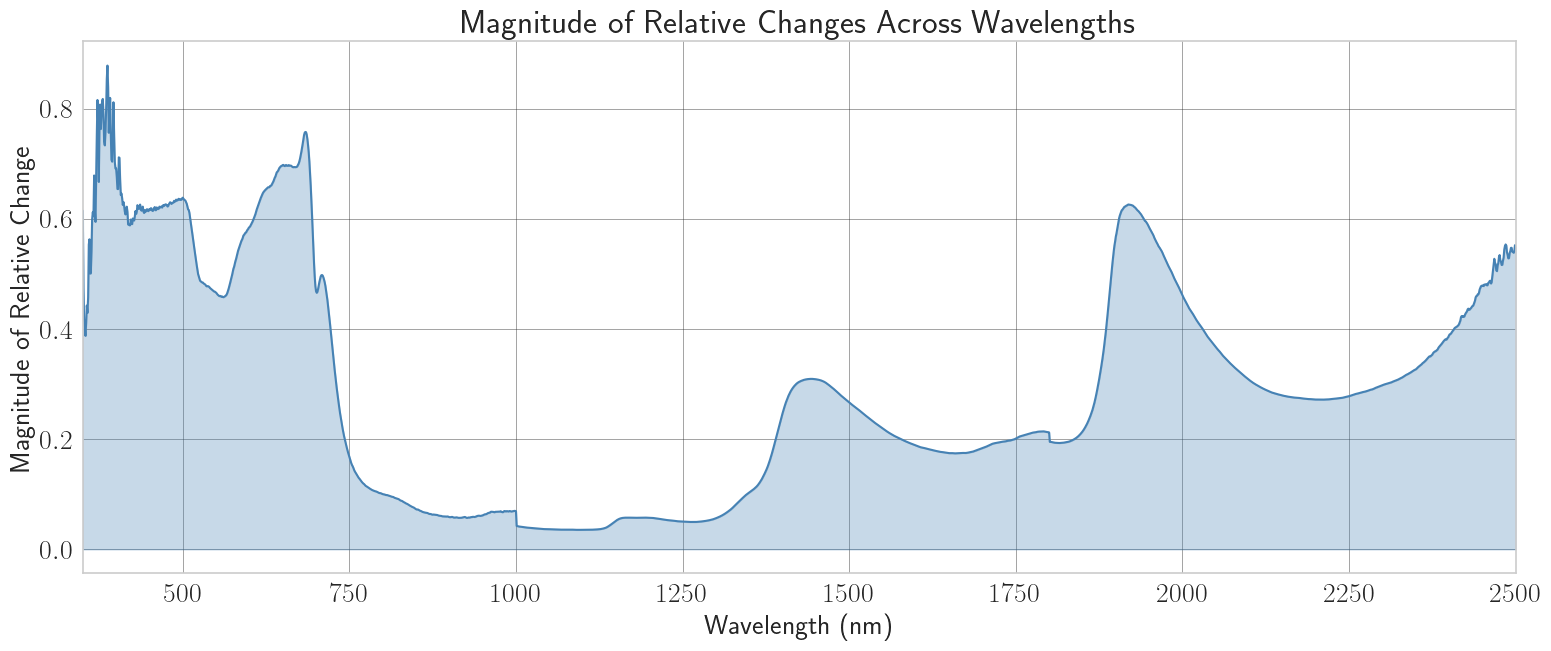

In [4]:
wavelengths = df_mag.columns.astype(float)
magnitudes_values = df_mag.iloc[0].values

# Plot 1: Line plot of magnitudes across wavelengths
plt.figure(figsize=(16, 7))
plt.plot(wavelengths, magnitudes_values, linewidth=1.5, color='steelblue')
plt.fill_between(wavelengths, magnitudes_values, alpha=0.3, color='steelblue')
plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Magnitude of Relative Change', fontsize=20)
plt.title('Magnitude of Relative Changes Across Wavelengths', fontsize=24, fontweight='bold')
plt.grid(True, alpha=0.5)
plt.xlim(wavelengths.min(), wavelengths.max())
plt.tight_layout()
plt.show()

Notar que la grafica es diferente pues ahora estamos tomando el cambio relativo entre plantas del mismo dia y no entre dias consecutivos de la misma planta


Sin embargo, los rangos importantes siguen siendo los mismos.

## Cambio relativo respecto a la referencia

In [5]:
all_magnitudes = []

for treatment in df_concatenation['Tratamiento'].unique():
    df_treat = df_concatenation[df_concatenation['Tratamiento'] == treatment]
    for plant_num in df_treat['Planta'].unique():
        df_plant = df_treat[df_treat['Planta'] == plant_num]
        
        # Extract the relevant columns (from column 2 onwards)
        data_cols = df_plant.iloc[:, 2:]

        # Calculate the magnitude for each column
        magnitudes = []

        for col in data_cols.columns:
            # Get the column values
            values = data_cols[col].values
            
            # Get the reference value from df_mag for this wavelength
            REF = df_mag[col].values[0]
            
            # Calculate |y-REF|/REF, |z-REF|/REF, etc. for all values
            if REF != 0:  # Avoid division by zero
                differences = np.abs(values - REF) / REF
                # Calculate the magnitude (Euclidean norm)
                magnitude = np.sqrt(np.sum(differences**2))
            else:
                magnitude = np.nan  # Handle zero reference value
            
            magnitudes.append(magnitude)

        # Create a row with treatment and plant info plus magnitudes
        row_data = {'Tratamiento': treatment, 'Planta': plant_num}
        row_data.update({col: mag for col, mag in zip(data_cols.columns, magnitudes)})
        
        all_magnitudes.append(row_data)

# Create the final dataframe with all magnitudes
df_all_magnitudes = pd.DataFrame(all_magnitudes)

# Display the result
print(f"Final shape: {df_all_magnitudes.shape}")
print(f"Treatments: {df_all_magnitudes['Tratamiento'].unique()}")
print(f"Number of plants: {len(df_all_magnitudes)}")
df_all_magnitudes.tail()

Final shape: (119, 2153)
Treatments: ['Control' 'Ralstonia' 'E_Hidrico' 'Ral_EH']
Number of plants: 119


,Tratamiento,Planta,350,351,352,353,354,355,356,357,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
114,Ral_EH,27,1.607823,1.573785,1.550952,1.535878,1.524542,1.542030,1.563529,1.564992,...,1.583660,1.585146,1.587358,1.587882,1.586392,1.586718,1.586921,1.587911,1.591260,1.590532
115,Ral_EH,28,1.597849,1.557971,1.543374,1.522220,1.506720,1.525708,1.542905,1.548401,...,1.596325,1.597848,1.600090,1.600618,1.599258,1.599631,1.599715,1.600702,1.604120,1.603581
116,Ral_EH,29,1.598622,1.556609,1.540855,1.521329,1.504552,1.522569,1.545614,1.547427,...,1.096056,1.100797,1.107972,1.109372,1.104156,1.105058,1.105166,1.108445,1.120377,1.117752
117,Ral_EH,30,1.570671,1.515515,1.496852,1.484180,1.467928,1.483356,1.505495,1.506507,...,1.555797,1.557527,1.560139,1.560699,1.558980,1.559393,1.559526,1.560763,1.564981,1.564247
118,Ral_EH,12,1.845295,1.793723,1.775079,1.760114,1.746023,1.762163,1.775973,1.778602,...,0.908892,0.914985,0.924492,0.925811,0.917354,0.917930,0.917588,0.921819,0.938747,0.934222


# Cambio Promedio Relativo Respecto a Planta de Referencia

In [6]:
df_means = df_all_magnitudes.groupby('Tratamiento').mean()

df_means.head()

,Planta,350,351,352,353,354,355,356,357,358,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
Tratamiento,,,,,,,,,,,,,,,,,,,,,
Control,15.5,2.157947,2.075285,2.033343,2.017636,2.008871,2.051994,2.090732,2.097240,2.126087,...,2.277817,2.279661,2.282247,2.282963,2.281471,2.281945,2.282166,2.283419,2.287392,2.286704
E_Hidrico,15.5,2.195573,2.125273,2.085048,2.074392,2.067921,2.103009,2.135689,2.135303,2.156044,...,2.268607,2.270531,2.273235,2.273986,2.272461,2.272981,2.273209,2.274560,2.278799,2.278108
Ral_EH,15.5,2.132951,2.072926,2.048591,2.025924,2.010378,2.037159,2.057593,2.059595,2.079257,...,1.800770,1.804083,1.809052,1.810040,1.806447,1.807017,1.806976,1.809217,1.817477,1.815597
Ralstonia,15.0,2.038832,1.976103,1.945412,1.929679,1.921826,1.955314,1.981036,1.983278,2.002929,...,1.854247,1.857056,1.861231,1.862126,1.859201,1.859752,1.859843,1.861787,1.868662,1.867212


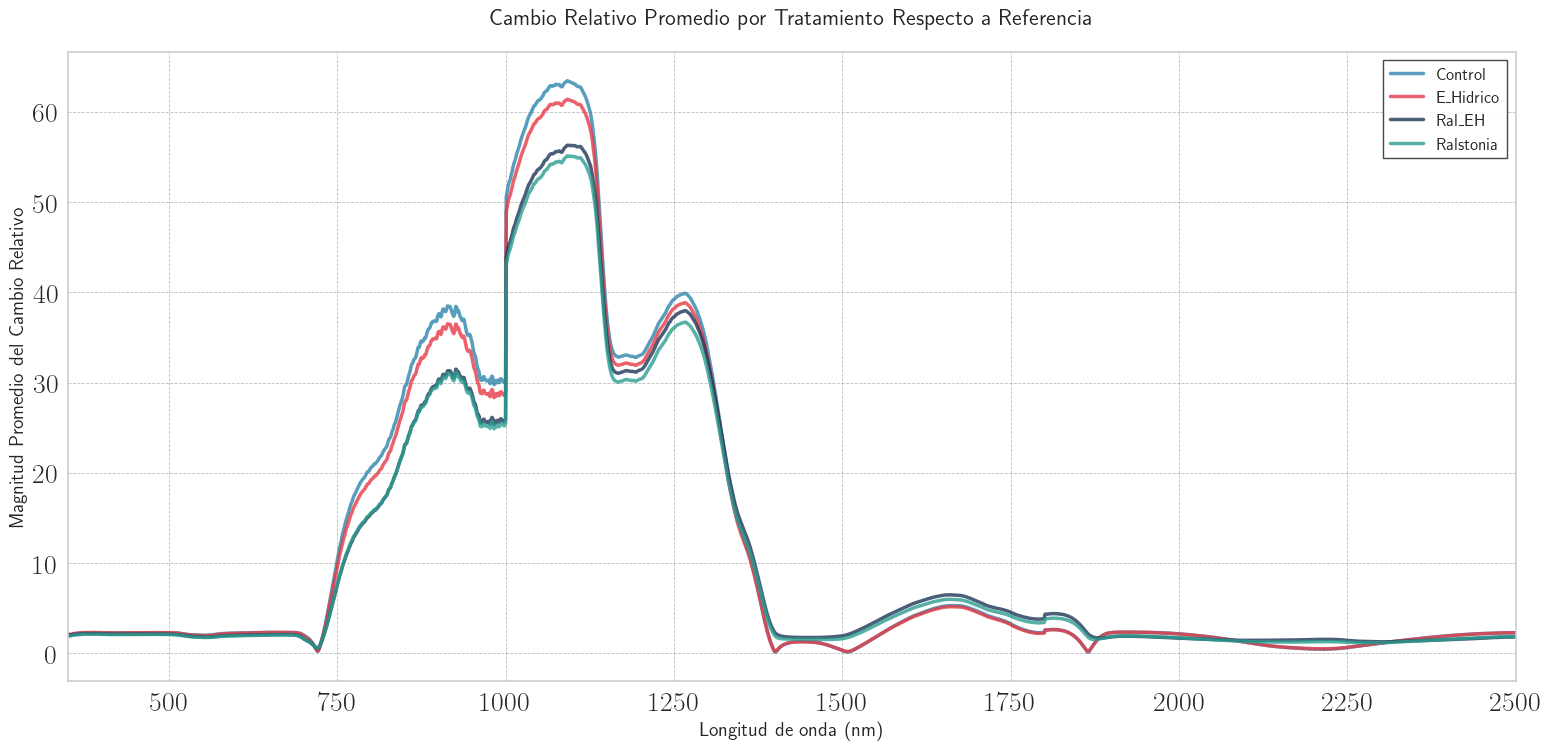

In [16]:
# Get the wavelengths (column names) and convert to float
wavelengths = df_means.iloc[:, 1:].columns.astype(float)

# Create the plot
plt.figure(figsize=(16, 8))

# Define colors for each treatment
colors = {
    'Control': '#2E86AB',
    'Tratamiento 1': '#A23B72',
    'Tratamiento 2': '#F18F01',
    'Tratamiento 3': '#6A994E',
    'Tratamiento 4': '#C73E1D'
}

# Plot each treatment
for treatment in df_means.index:
    magnitudes = df_means.loc[treatment].iloc[1:].values
    
    # Use predefined color if available, otherwise use default
    color = colors.get(treatment, None)
    
    plt.plot(wavelengths, magnitudes, 
             label=treatment, 
             linewidth=2.5, 
             alpha=0.8,
             color=color,) 

plt.xlabel('Longitud de onda (nm)', fontsize=14, fontweight='bold')
plt.ylabel('Magnitud Promedio del Cambio Relativo', fontsize=14, fontweight='bold')
plt.title('Cambio Relativo Promedio por Tratamiento Respecto a Referencia', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=12, loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim(wavelengths.min(), wavelengths.max())
plt.tight_layout()
plt.show()